In [1]:
import os

import numpy as np
import xarray as xr
import cfgrib
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

from dask.distributed import Client, LocalCluster

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16, "axes.labelsize":16, "axes.titlesize":16,
                     "font.weight": "bold","axes.labelweight":"bold","axes.titleweight":"bold",
                    "figure.titleweight":"bold", "figure.titlesize":"large" })

from ambiance import Atmosphere
from aostools import climate

from Eval import plot_map_xr, plot_profile_xr, make_gif
from Eval import var_info, coord_info, results_dir


# Open dataset

In [2]:
dataset = 'geos'

In [3]:
data_dir = '/gemeinsam_tmp/SSW_2021/'

In [4]:
#client = Client(LocalCluster(host='192.168.154.3')) # change to ora's IP adress: 192.168.135.33
client = Client(LocalCluster(host='192.168.155.33'))

/home/ap1_12/.conda/envs/nwp-py3/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35745 instead
  http_address["port"], self.http_server.port


In [5]:
client

Client Scheduler: tcp://192.168.155.33:40565 Dashboard: http://192.168.155.33:35745/status,Cluster Workers: 8 Cores: 64 Memory: 810.22 GB


## GEOS-FP

In [6]:
infiles = f'{data_dir}/geos-fp/geos5_subset*.nc'
ds_geos = xr.open_mfdataset(
    infiles,
    combine='nested',
    concat_dim = 'time',
    parallel = True,
)


In [7]:
wrong_idx = [300, 250, 200, 150]
for i in wrong_idx:
    ds_geos = ds_geos.where(ds_geos.lev != i, drop=True )

/home/ap1_12/.conda/envs/nwp-py3/lib/python3.6/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/ap1_12/.conda/envs/nwp-py3/lib/python3.6/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/hom

In [8]:
ds_geos

,Array,Chunk
Bytes,8.65 GB,93.03 MB
Shape,"(93, 28, 721, 1152)","(1, 28, 721, 1152)"
Count,1120 Tasks,93 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,8.65 GB,93.03 MB
Shape,"(93, 28, 721, 1152)","(1, 28, 721, 1152)"
Count,1120 Tasks,93 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


### Test Plots

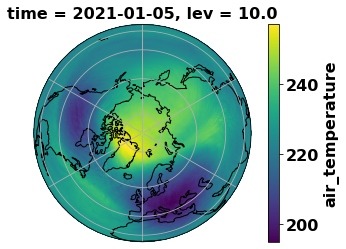

In [15]:
p = ds_geos['t'].sel(
    **{coord_info.get(dataset).get('p'): 10},
    time = '2021-01-05T00'
    ).plot(
        subplot_kws=dict(projection=ccrs.Orthographic(0, 90)), 
        transform=ccrs.PlateCarree(),
        #robust = True
)
p.axes.set_global()
p.axes.coastlines()
p.axes.gridlines()

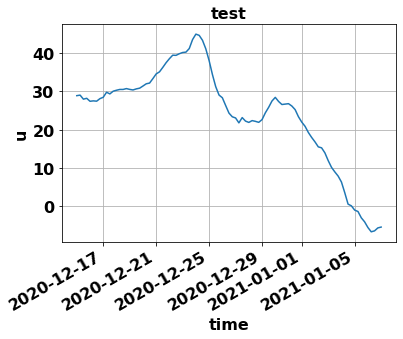

In [18]:
t = ds_geos.time[0]
arr = ds_geos['u'].sel(
    **{coord_info.get(dataset).get('lat'): 60},
    **{coord_info.get(dataset).get('p'): 10}
    )
arr = arr.mean(dim = coord_info.get(dataset).get('lon'))
p = arr.plot()

ax = p[0].axes

ax.set_title('test')
ax.grid()

pass

## testtt


In [9]:
var = 'u'
t = ds_geos.time[0]

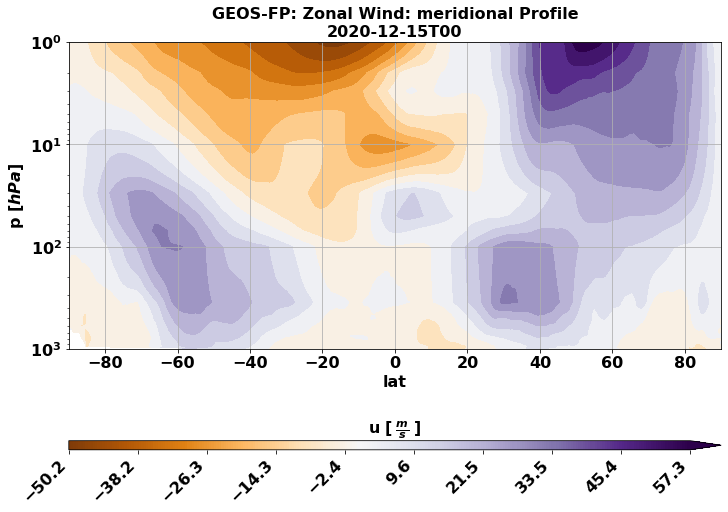

In [10]:
sel = ds_geos[var].sel(**{coord_info.get(dataset).get('time'): t.data},).load()
plot_profile_xr(sel, t, dataset,  mode='meridional',
                norm_bound=None, norm_type = 'diverging', 
                cmap = plt.cm.PuOr, levels=20,
                save=False )

### Plot u zonal profiles: ~2 min

In [9]:
var = 'u'

In [14]:
sel_all = ds_geos[var].sel(
#               **{coord_info.get(dataset).get('lat'): slice(0, 10)},
#               **{coord_info.get(dataset).get('p'): slice(500, 1)}
).load()

mini = sel_all.min().data
maxi = sel_all.max().data

for t in sel_all.time:
    sel = sel_all.sel(**{coord_info.get(dataset).get('time'): t.data},) 
  
    plot_profile_xr(sel, t, dataset,  mode='meridional',
                    norm_bound=(mini, maxi), norm_type = 'diverging', 
                    cmap = plt.cm.PuOr, levels=20,
                    save=True )

In [15]:
file_folder = results_dir.get(dataset) + '/u_meridional_profile'
make_gif(file_folder, dataset,  duration=150)

### Plot t (°C) zonal profiles: ~6 min

In [16]:
var = 't'

In [17]:
sel_all = ds_geos[var].sel(
#               **{coord_info.get(dataset).get('lat'): slice(0, 10)},
#               **{coord_info.get(dataset).get('p'): slice(500, 1)}
).load() - 273.15
sel_all = sel_all.rename('tc')

mini = sel_all.min().data
maxi = sel_all.max().data

In [18]:
for t in sel_all.time:
    sel = sel_all.sel(**{coord_info.get(dataset).get('time'): t.data},)
    
    plot_profile_xr(sel, t, dataset, mode='meridional',
                    norm_bound=(mini, maxi), norm_type = 'diverging', 
                    cmap = plt.cm.RdBu_r, levels=20, 
                    save=True )

In [19]:
file_folder = results_dir.get(dataset) + '/tc_meridional_profile'
make_gif(file_folder, dataset,  duration=150)

### Plot Geopotential maps: ~10 min

In [20]:
p_level = 10
var = 'z'

In [ ]:
sel_all = ds_geos[var].sel(
                **{coord_info.get(dataset).get('lat'): slice(0, 90)},
                **{coord_info.get(dataset).get('p'): p_level},
                ).compute()
maxi = sel_all.max().data
mini = sel_all.min().data

In [ ]:
for t in sel_all.time:
    sel = sel_all.sel(**{coord_info.get(dataset).get('time'): t.data})
    plot_map_xr(sel, t, dataset, figsize=(6,6),
             projection=ccrs.Orthographic(central_longitude=0, central_latitude=90),
             norm=True, norm_bound=(mini, maxi), norm_type='linear',
             levels=20, cmap=plt.cm.Purples,
             save=True
             )

In [ ]:
file_folder = results_dir.get(dataset) + 'z_' + str(int(p_level)) + 'hPa'
make_gif(file_folder, dataset,  duration=150)

### Plot Temperature (°C) maps: ~10 min

In [22]:
p_level = 10
var = 't'

In [23]:
sel_all = ds_geos[var].sel(
                **{coord_info.get(dataset).get('lat'): slice(0, 90, -1)},
                **{coord_info.get(dataset).get('p'): p_level},
                ).load() - 273.15

sel_all = sel_all.rename('tc')

maxi = sel_all.max().data
mini = sel_all.min().data

In [24]:
mini, maxi

(array(-92.48689, dtype=float32), array(10.303558, dtype=float32))

In [25]:
for t in sel_all.time:
    sel = sel_all.sel(**{coord_info.get(dataset).get('time'): t.data})
    plot_map_xr(sel, t, dataset, figsize=(6,6),
             projection=ccrs.Orthographic(central_longitude=0, central_latitude=90),
             norm=True, norm_bound=(mini,0, maxi), norm_type='diverging',
             levels=20, cmap=plt.cm.RdBu_r,
             save=True
             )

In [26]:
file_folder = results_dir.get(dataset) + '/tc_' + str(int(p_level)) + 'hPa'
make_gif(file_folder, dataset,  duration=150)

### Plot Geopotential profiles: ~10 min

# EP Flux tests

In [19]:
t = ds_geos.time[0:5]

In [20]:
test_data = ds_geos.sel(
    #isobaricInhPa=10,
    time = t.data
    ).load()

In [21]:
test_data.dims

Frozen(SortedKeysDict({'time': 5, 'lev': 28, 'lat': 721, 'lon': 1152}))

In [22]:
ep1, ep2, ep1_div, ep2_div = climate.ComputeEPfluxDivXr(test_data['u'],test_data['v'], test_data['t'],
                lat=coord_info.get(dataset).get('lat'), lon=coord_info.get(dataset).get('lon'),
                pres=coord_info.get(dataset).get('p'), time=coord_info.get(dataset).get('time') )

ep1.name = 'EP1'
ep2.name = 'EP2'
ep1_div.name = 'EP1_div'
ep2_div.name = 'EP2_div'

In [23]:
ep1.dims, ep1.shape

(('time', 'lev', 'lat'), (5, 28, 721))

In [28]:
ep1

<xarray.DataArray 'EP1' (time: 5, lev: 28, lat: 721)>
array([[[            nan,             nan,             nan, ...,
         -1.98229477e-01, -9.42170918e-02,  2.43928691e-04],
        [            nan,             nan,             nan, ...,
         -1.33110255e-01,  8.36264268e-02,  4.53525106e-04],
        [            nan,             nan,             nan, ...,
          2.17975199e-01,  4.98182513e-02,  1.47713552e-04],
        ...,
        [-2.26889714e-03,  6.13890737e-02,  1.88599482e-01, ...,
         -6.38178158e+00, -7.52631307e-01, -1.29665798e-02],
        [-1.20162964e-04, -1.59774348e-02, -8.40288773e-02, ...,
          9.44710255e+00,  2.63161898e+00,  2.04535592e-02],
        [ 2.92883982e-04,  3.23219299e-02,  5.58789559e-02, ...,
         -8.00141048e+00, -3.92415357e+00, -4.85568568e-02]],

       [[            nan,             nan,             nan, ...,
          3.11699450e-01,  2.02426389e-02,  1.82469681e-04],
        [            nan,             nan,             nan, ...,
          5.35371602e-01,  1.70139417e-01,  4.26292419e-04],
        [            nan,             nan,             nan, ...,
         -2.31314767e-02,  2.32628714e-02,  2.66816875e-04],
...
        [-2.18073532e-04, -8.48710835e-02, -2.39523351e-01, ...,
         -8.95317912e-01, -2.07891178e+00,  1.23969186e-02],
        [ 3.23189624e-06, -2.92518409e-03,  5.64458640e-03, ...,
          6.91813171e-01,  6.62136495e-01, -1.76323787e-03],
        [ 3.15242346e-06, -5.03789037e-02, -1.74893409e-01, ...,
         -3.11100268e+00, -1.09415686e+00,  1.79036462e-03]],

       [[            nan,             nan,             nan, ...,
         -2.11425114e+00, -1.55446875e+00, -1.03420683e-03],
        [            nan,             nan,             nan, ...,
         -2.73357654e+00, -1.80001664e+00,  8.62969318e-04],
        [            nan,             nan,             nan, ...,
         -1.20030129e+00, -3.88015747e-01, -2.44140625e-04],
        ...,
        [-1.32454769e-03,  1.66943446e-01,  5.73590815e-01, ...,
          3.74216032e+00,  1.51063371e+00,  4.69563790e-02],
        [-6.69691290e-05, -1.33767024e-01, -5.37350118e-01, ...,
          1.61691895e+01,  4.63712549e+00, -4.31315089e-03],
        [ 3.02738626e-04, -1.63766015e-02, -8.12395960e-02, ...,
         -1.54442549e+01, -5.44474268e+00, -2.71267374e-04]]])
Coordinates:
  * time     (time) datetime64[ns] 2020-12-15 2020-12-15T06:00:00 ... 2020-12-16
  * lev      (lev) float64 1e+03 975.0 950.0 925.0 900.0 ... 5.0 3.0 2.0 1.0
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0

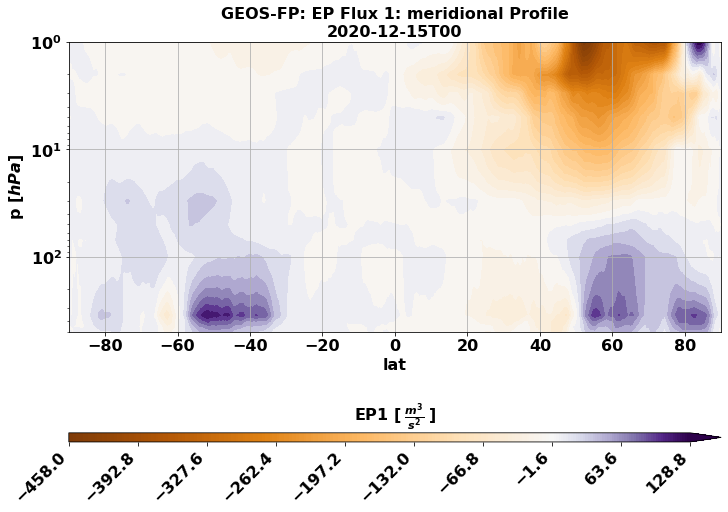

In [24]:
t = ep1.time[0]

sel = ep1.sel(time = t.data,
#                    **{coord_info.get(dataset).get('lat'): slice(0, 10)},
                   **{coord_info.get(dataset).get('p'): slice(500, 1)}) 

#norm_bound=(-0.5, 0.5)

# meridional    zonal
plot_profile_xr(sel, t, dataset, mode='meridional', average = False,
                norm_bound=None, norm_type = 'diverging', 
                cmap = plt.cm.PuOr, levels=50,
                save=False )

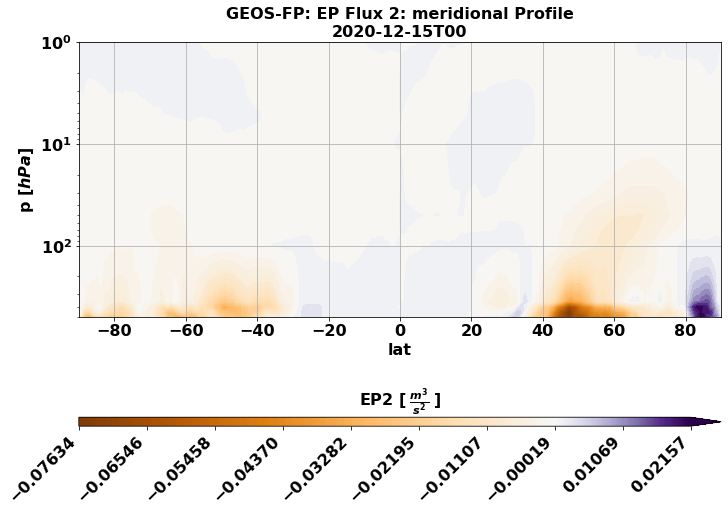

In [25]:
t = ep1.time[0]

sel = ep2.sel(time = t.data,
#                    **{coord_info.get(dataset).get('lat'): slice(0, 10)},
                   **{coord_info.get(dataset).get('p'): slice(500, 1)}
                  ) 

#norm_bound=(-0.5, 0.5)

# meridional    zonal
plot_profile_xr(sel, t, dataset=dataset, mode='meridional', average = False,
                norm_bound=None, norm_type = 'diverging', 
                cmap = plt.cm.PuOr, levels=50,
                save=False )

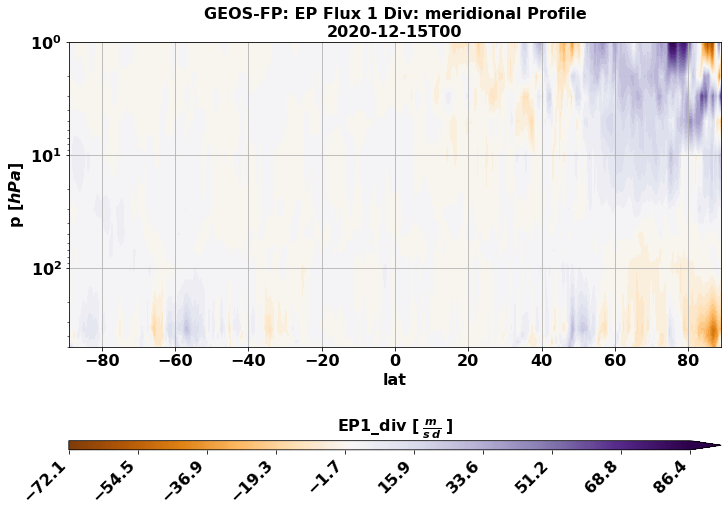

In [26]:
t = ep1.time[0]

sel = ep1_div.sel(time = t.data,
                       **{coord_info.get(dataset).get('lat'): slice(-89, 89)},
                       **{coord_info.get(dataset).get('p'): slice(500, 1)},
                      ) 

norm_bound=(-1e+2,1e+2)

# meridional    zonal
plot_profile_xr(sel, t, dataset=dataset, mode='meridional', average = False,
                norm_bound=None, norm_type = 'diverging', 
                cmap = plt.cm.PuOr, levels=50,
                save=False )

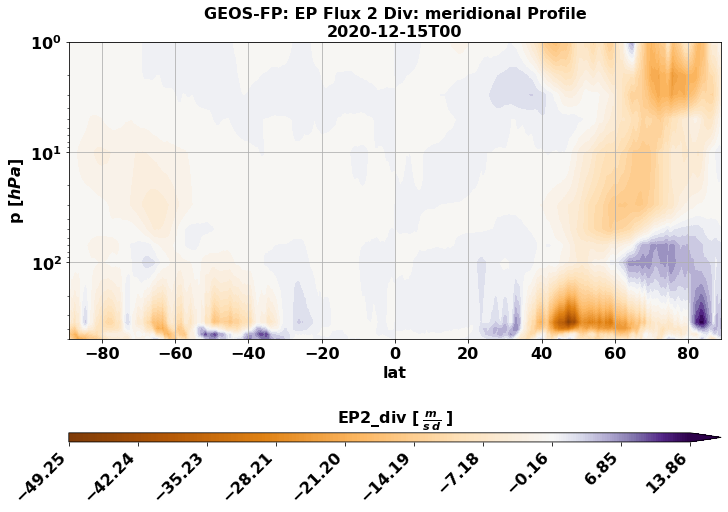

In [27]:
t = ep1.time[0]

sel = ep2_div.sel(time = t.data)
sel = sel.sel(**{coord_info.get(dataset).get('lat'): slice(-89, 89)},
              **{coord_info.get(dataset).get('p'): slice(
                                              #sel[coord_info.get(dataset).get('p')][4].data,
                                              500,
                                              sel[coord_info.get(dataset).get('p')][-1].data)},
                 ) 
, 
                       

# meridional    zonal
plot_profile_xr(sel, t, dataset=dataset, mode='meridional', average = False,
                norm_bound=None, norm_type = 'diverging', 
                cmap = plt.cm.PuOr, levels=50,
                save=False )

In [ ]:
ep2.sel(**{coord_info.get(dataset).get('p'): 10},
        **{coord_info.get(dataset).get('lat'): 50}
       ).plot()

In [ ]:
ds_geos[coord_info.get(dataset).get('p')]

### Compote EP Eddy Heat

ds_geos

In [29]:
test_data = ds_geos.sel(
    **{coord_info.get(dataset).get('p'): slice(300, 5)},
    **{coord_info.get(dataset).get('lat'): slice(45, 75)}
       ).load()

In [30]:
test_data

<xarray.Dataset>
Dimensions:  (lat: 121, lev: 6, lon: 1152, time: 93)
Coordinates:
  * time     (time) datetime64[ns] 2020-12-15 2020-12-15T06:00:00 ... 2021-01-07
  * lev      (lev) float64 100.0 70.0 50.0 30.0 10.0 5.0
  * lat      (lat) float64 45.0 45.25 45.5 45.75 46.0 ... 74.25 74.5 74.75 75.0
  * lon      (lon) float64 -180.0 -179.7 -179.4 -179.1 ... 179.1 179.4 179.7
Data variables:
    omega    (time, lev, lat, lon) float32 -0.01999 0.01297 ... 0.0006029
    t        (time, lev, lat, lon) float32 223.4 223.7 224.1 ... 240.2 240.2
    v        (time, lev, lat, lon) float32 0.04225 0.239 0.1856 ... 18.73 18.39
    u        (time, lev, lat, lon) float32 18.62 18.75 18.51 ... 1.353 1.4 1.454
Attributes:
    title:                GEOS5 FP 3d assimilated state on pressure levels
    Conventions:          COARDS\nGrADS
    dataType:             Grid
    history:              Tue Jan 11 06:01:40 EST 2022 : imported by GrADS Da...
    extra_das_attribute:  This is an example of metadata added using a supple...

In [31]:
ep1, ep2, ep1_div, ep2_div = climate.ComputeEPfluxDivXr(test_data['u'], test_data['v'], test_data['t'],
                lat=coord_info.get(dataset).get('lat'), lon=coord_info.get(dataset).get('lon'),
                pres=coord_info.get(dataset).get('p'), time=coord_info.get(dataset).get('time') )

ep1.name = 'EP1'
ep2.name = 'EP2'
ep1_div.name = 'EP1_div'
ep2_div.name = 'EP2_div'

In [32]:
eddy_heat = ep2
coslat_weights = np.cos(np.deg2rad(eddy_heat[coord_info.get(dataset).get('lat')]))
coslat_weights.name = "weights"
eddy_heat = eddy_heat.weighted(coslat_weights)
eddy_heat = eddy_heat.mean(dim = coord_info.get(dataset).get('lat'))

In [33]:
eddy_heat

<xarray.DataArray 'EP2' (time: 93, lev: 6)>
array([[-9.04914509e-03, -6.54489694e-03, -5.59778456e-03,
        -2.79020445e-03, -7.45491893e-04, -5.89805365e-04],
       [-7.92142206e-03, -6.18875103e-03, -5.43255249e-03,
        -2.70121616e-03, -6.95272443e-04, -5.95469237e-04],
       [-7.91604238e-03, -6.24667637e-03, -5.22220499e-03,
        -2.60333536e-03, -7.34236048e-04, -7.86461854e-04],
       [-6.87420593e-03, -5.60814325e-03, -4.94684463e-03,
        -2.39543043e-03, -8.30733553e-04, -1.01630475e-03],
       [-7.09837604e-03, -5.71570469e-03, -4.80449145e-03,
        -2.51067940e-03, -9.64439873e-04, -1.47785988e-03],
       [-5.67677165e-03, -4.83037671e-03, -4.27588996e-03,
        -2.03874707e-03, -1.05329285e-03, -2.15808650e-03],
       [-6.03315545e-03, -4.83499226e-03, -4.07645740e-03,
        -2.28053892e-03, -1.20581132e-03, -2.90929120e-03],
       [-4.88546524e-03, -4.14495416e-03, -3.55288820e-03,
        -1.95653659e-03, -1.48879568e-03, -3.75176746e-03],
       [-5.50265601e-03, -4.27621552e-03, -3.49173724e-03,
        -2.27054552e-03, -1.64448156e-03, -4.02784512e-03],
       [-4.57023790e-03, -3.33879793e-03, -3.23569770e-03,
        -2.19157093e-03, -1.75426897e-03, -3.92349455e-03],
...
       [-5.37595546e-03, -3.95681585e-03, -3.81727115e-03,
        -2.67862745e-03, -1.23969625e-03, -1.30592730e-03],
       [-5.99093136e-03, -4.47431528e-03, -4.01164355e-03,
        -2.40009515e-03, -8.52096393e-04, -9.21320499e-04],
       [-4.80947223e-03, -3.40141280e-03, -3.29131618e-03,
        -2.12900551e-03, -5.80121578e-04, -6.88406944e-04],
       [-5.14822361e-03, -3.85336324e-03, -3.38778326e-03,
        -1.63299636e-03, -2.82895415e-04, -3.75347401e-04],
       [-4.46827869e-03, -3.19845160e-03, -2.82732757e-03,
        -1.60361879e-03, -1.62906426e-04, -4.54848847e-05],
       [-5.51177926e-03, -3.89339653e-03, -3.38096087e-03,
        -1.35892736e-03, -1.01218617e-04,  3.21976802e-05],
       [-4.72578630e-03, -3.34415711e-03, -2.79710705e-03,
        -1.21249330e-03, -3.93775982e-05,  1.99539040e-04],
       [-5.72083367e-03, -3.82738450e-03, -2.86867110e-03,
        -9.56979397e-04,  4.73753193e-05,  2.42400893e-04],
       [-5.28911173e-03, -3.40150064e-03, -2.66529390e-03,
        -9.06503400e-04,  1.99517909e-04,  4.44148879e-04],
       [-6.95834190e-03, -4.27253386e-03, -2.97778759e-03,
        -9.49723709e-04,  2.75195588e-04,  6.41982132e-04]])
Coordinates:
  * time     (time) datetime64[ns] 2020-12-15 2020-12-15T06:00:00 ... 2021-01-07
  * lev      (lev) float64 100.0 70.0 50.0 30.0 10.0 5.0

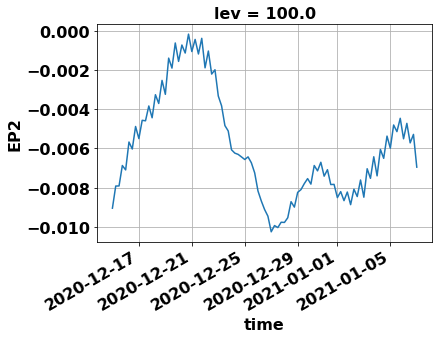

In [35]:
p = eddy_heat.sel(**{coord_info.get(dataset).get('p'): 100}
       ).plot()

ax = p[0].axes

ax.grid()

pass

## Compute whole timeseries EP (loading data ~5:30 min | EP calc ~2:30 min)

In [ ]:
test_data = ds_geos.load()

In [ ]:
ep1, ep2, ep1_div, ep2_div = climate.ComputeEPfluxDivXr(test_data['u'], test_data['v'], test_data['t'],
                lat=coord_info.get(dataset).get('lat'), lon=coord_info.get(dataset).get('lon'),
                pres=coord_info.get(dataset).get('p'), time=coord_info.get(dataset).get('time') )

ep1.name = 'EP1'
ep2.name = 'EP2'
ep1_div.name = 'EP1_div'
ep2_div.name = 'EP2_div'

In [ ]:
ep2.sel(**{coord_info.get(dataset).get('p'): 10},
        **{coord_info.get(dataset).get('lat'): 50}
       ).plot()

### Compute EP1 profile series ~ 1 min

In [ ]:
sel_all = ep1.sel(
#               **{coord_info.get(dataset).get('lat'): slice(0, 10)},
              **{coord_info.get(dataset).get('p'): slice(500, 1)})

mini = sel_all.min().data
maxi = sel_all.max().data

for t in sel_all.time:
    sel = sel_all.sel(time = t.data) 
    
    plot_profile_xr(sel, t, dataset=dataset, mode='meridional', average = False,
                    norm_bound=(mini,maxi), norm_type = 'diverging', 
                    cmap = plt.cm.PuOr, levels=50,
                    save=True )

In [ ]:
file_folder = results_dir.get(dataset) + '/EP1_meridional_profile'
make_gif(file_folder, dataset,  duration=150)

### Compute EP2 profile series ~ 1 min

In [ ]:
sel_all = ep2.sel(
#               **{coord_info.get(dataset).get('lat'): slice(0, 10)},
              **{coord_info.get(dataset).get('p'): slice(500, 1)})

mini = sel_all.min().data
maxi = sel_all.max().data

for t in sel_all.time:
    sel = sel_all.sel(time = t.data) 

    plot_profile_xr(sel, t, dataset=dataset, mode='meridional', average = False,
                    norm_bound=(mini,maxi), norm_type = 'diverging', 
                    cmap = plt.cm.PuOr, levels=50,
                    save=True )

In [ ]:
file_folder = results_dir.get(dataset) + '/EP2_meridional_profile'
make_gif(file_folder, dataset,  duration=150)

### Compute EP1_div profile series ~ 1 min

In [ ]:
sel_all = ep1_div.sel(
              **{coord_info.get(dataset).get('lat'): slice(-89, 89)},
              **{coord_info.get(dataset).get('p'): slice(500, 1)})

mini = sel_all.min().data
maxi = sel_all.max().data

for t in sel_all.time:
    sel = sel_all.sel(time = t.data) 

    plot_profile_xr(sel, t, dataset=dataset, mode='meridional', average = False,
                    norm_bound=(mini,maxi), norm_type = 'diverging', 
                    cmap = plt.cm.PuOr, levels=50,
                    save=True )

In [ ]:
file_folder = results_dir.get(dataset) + '/EP1_div_meridional_profile'
make_gif(file_folder, dataset,  duration=150)

### Compute EP2_div profile series ~ 1 min

In [ ]:
sel_all = ep2_div.sel(
              **{coord_info.get(dataset).get('lat'): slice(-89, 89)},
              **{coord_info.get(dataset).get('p'): slice(500, 1)})

mini = sel_all.min().data
maxi = sel_all.max().data

for t in sel_all.time:
    sel = sel_all.sel(time = t.data) 

    plot_profile_xr(sel, t, dataset=dataset, mode='meridional', average = False,
                    norm_bound=(mini,maxi), norm_type = 'diverging', 
                    cmap = plt.cm.PuOr, levels=50,
                    save=True )

In [ ]:
file_folder = results_dir.get(dataset) + '/EP2_div_meridional_profile'
make_gif(file_folder, dataset,  duration=150)

# VMFC

In [36]:
filter_by_keys={'typeOfLevel': 'isobaricInhPa'}
infiles = f'{data_dir}geos-fp/vmfc_20201215_20210107.nc'
ds_geos_vmfc = xr.open_mfdataset(
    infiles,
    #engine='cfgrib',
    #combine='nested',
    #concat_dim = 'time',
    parallel = True,
    #backend_kwargs={'filter_by_keys': filter_by_keys},
).load()


In [39]:
ds_geos_vmfc

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 32, latitude: 721, time: 93)
Coordinates:
  * time           (time) datetime64[ns] 2020-12-15 ... 2021-01-07
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 975.0 950.0 ... 3.0 2.0 1.0
  * latitude       (latitude) float64 -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
Data variables:
    vmfc           (time, isobaricInhPa, latitude) float64 0.0 0.0 ... 0.0

In [40]:
t = ds_geos_vmfc.time[0]

sel = ds_geos_vmfc['vmfc'].sel(time = t.data)
sel = sel.sel(
            #**{coord_info.get('era5').get('lat'): slice(-89, 89)},
            **{coord_info.get('era5').get('p'): slice(500,1)},
             )

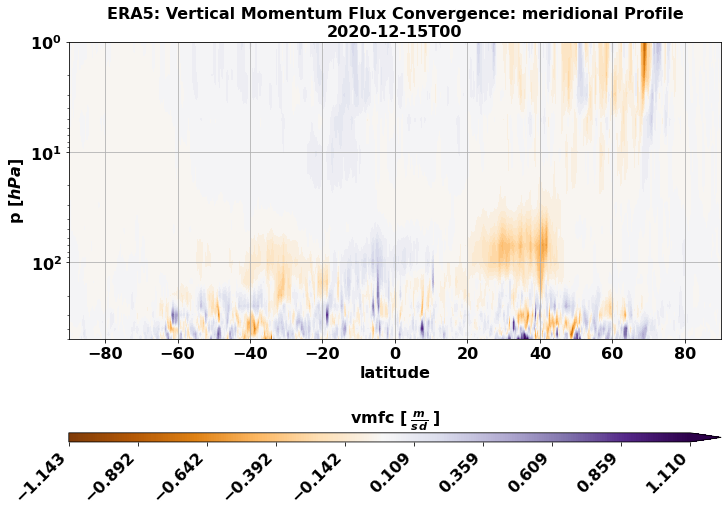

In [42]:
# meridional    zonal
plot_profile_xr(sel, t, dataset='era5', mode='meridional', average = False,
                norm_bound=None, norm_type = 'diverging', 
                cmap = plt.cm.PuOr, levels=50,
                save=False )

### Compute VMFC profile series ~ 1 min

In [ ]:
sel_all = ds_geos_vmfc['vmfc'].sel(
              #**{coord_info.get(dataset).get('lat'): slice(-89, 89)},
              **{coord_info.get(dataset).get('p'): slice(500, 1)})

mini = sel_all.min().data
maxi = sel_all.max().data

for t in sel_all.time:
    sel = sel_all.sel(time = t.data) 

    plot_profile_xr(sel, t, dataset=dataset, mode='meridional', average = False,
                    norm_bound=(mini,maxi), norm_type = 'diverging', 
                    cmap = plt.cm.PuOr, levels=50,
                    save=True )

In [ ]:
file_folder = results_dir.get(dataset) + '/vmfc_meridional_profile'
make_gif(file_folder, dataset,  duration=150)